<img src=attachment:2e89d2de-a137-4d65-901f-8d70764d5558.png width=1000>
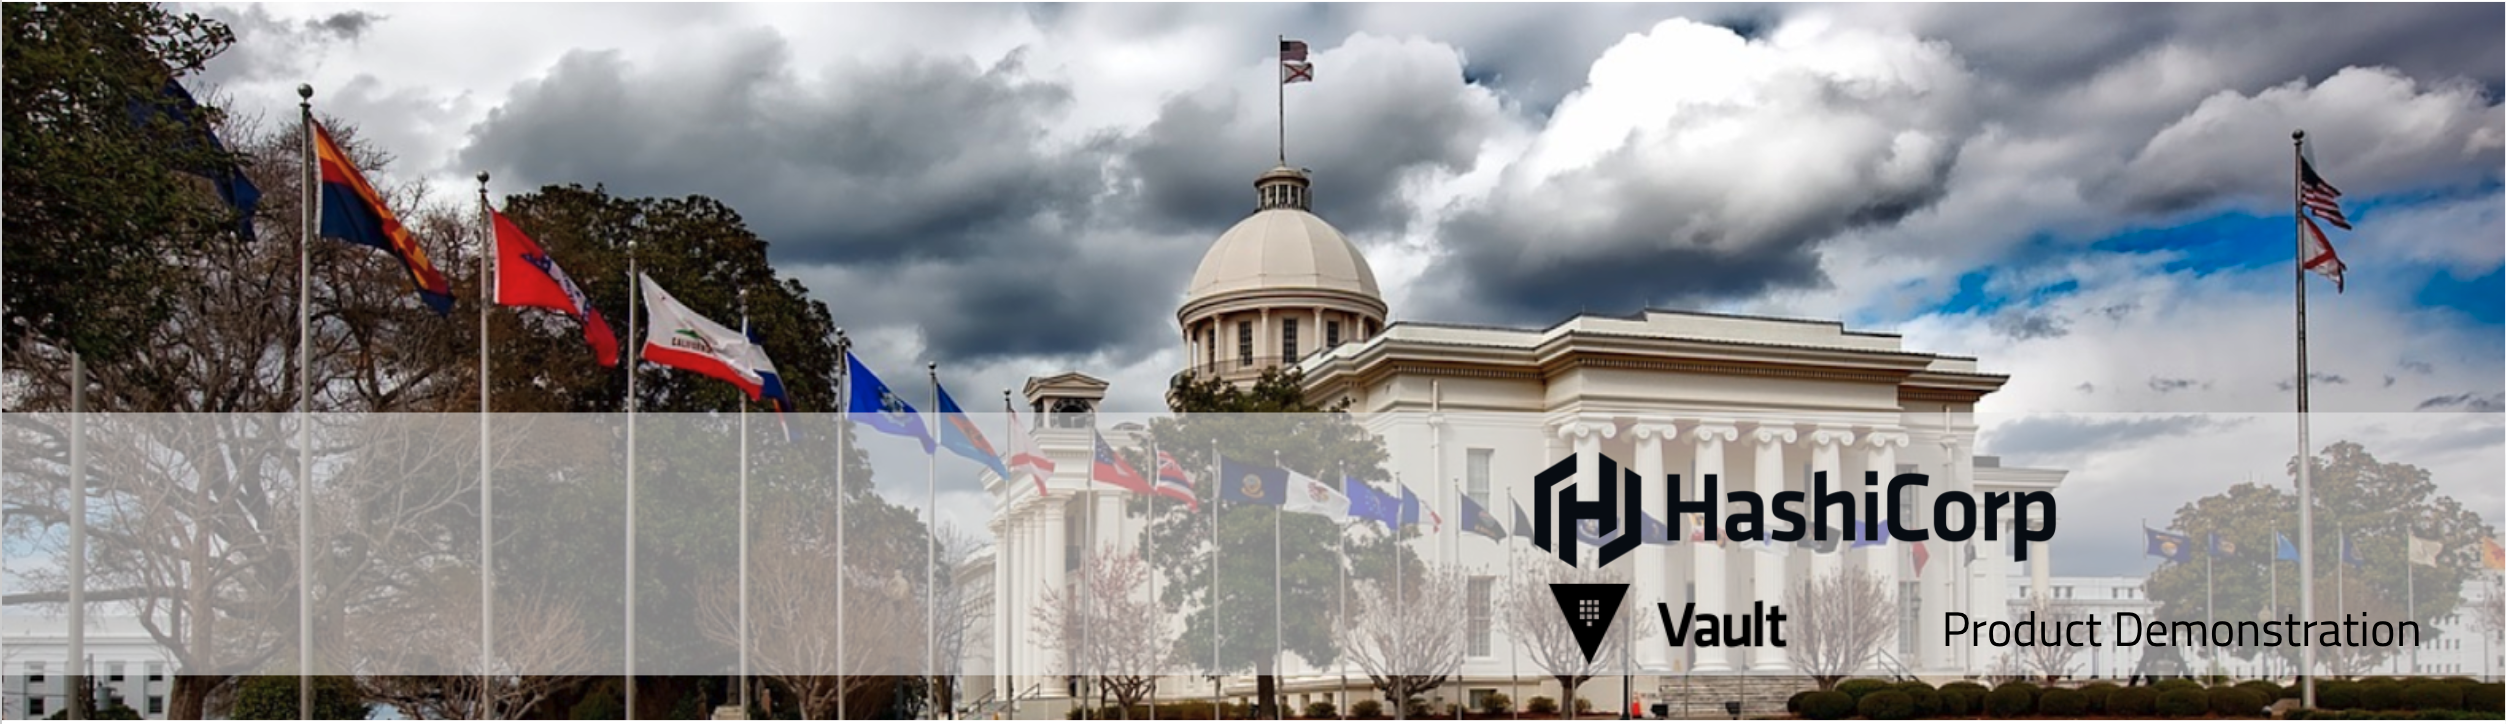

# Signed SSH Certificates
---
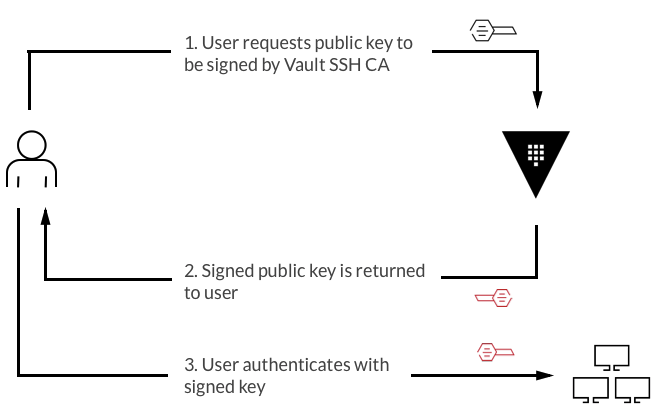

## Business Value of Capability
The signed SSH certificates is the simplest and most powerful in terms of setup complexity and in terms of being platform agnostic. By leveraging Vault's powerful CA capabilities and functionality built into OpenSSH, clients can SSH into target hosts using their own local SSH keys.
### Setup
---

In [ ]:
export VAULT_ADDR=http://127.0.0.1:8200
export VAULT_TOKEN=root
export VAULT_SKIP_VERIFY=true
export LICENSE=/Users/larryebaum/.licenses/vault.json
export AWS_TAG_Name=UCV08-larryebaum-vault-demo
export AWS_TAG_owner=larryebaum@hashicorp.com
export AWS_TAG_se_region=public-sector

In [ ]:
vault login root

In [ ]:
vault status

In [ ]:
vault -version

In [ ]:
#license the server
curl \
  --header "X-Vault-Token: root" \
  --request PUT \
  --data "@${LICENSE}" \
  http://127.0.0.1:8200/v1/sys/license

### Demo
---
**Enable/mount the Vault secrets engine to a path**

In [ ]:
vault secrets enable -path=ssh-client-signer ssh

**Configure Vault with a CA for signing client keys** (use your CA or let Vault function as a CA)

In [ ]:
vault write ssh-client-signer/config/ca generate_signing_key=true

**Add public SSH key to target's SSH configuration**

In [ ]:
curl -s -o ./trusted-user-ca-keys.pem http://127.0.0.1:8200/v1/ssh-client-signer/public_key

**or**

In [ ]:
vault read -field=public_key ssh-client-signer/config/ca > ./trusted-user-ca-keys.pem

**Create a target VM**

In [ ]:
eval $(doormat aws --account se_demos_dev)
export InstanceID=$(aws ec2 run-instances --image-id ami-02354e95b39ca8dec --key-name larryebaum-hashi-aws \
  --instance-type t2.micro --associate-public-ip-address --subnet-id subnet-0a7bd242074b0b3ef --security-group-ids sg-0c920c161bc15804e \
  --tag-specifications 'ResourceType=instance,Tags=[{Key=Name,Value="'"$AWS_TAG_Name"'"},{Key=owner,Value="'"$AWS_TAG_owner"'"},{Key=TTL,Value=1},{Key=se-region,Value="'"$AWS_TAG_se_region"'"},{Key=purpose,Value=demo}]'\
  | jq '.Instances[].InstanceId' | sed 's/"//g')
echo $InstanceID

**Extract Public IP Address**

In [ ]:
export pubIP_address=`aws ec2 describe-instances --instance-ids $InstanceID | jq '.Reservations[].Instances[].NetworkInterfaces[].PrivateIpAddresses[].Association.PublicIp' | sed 's/"//g'`
echo $pubIP_address

In [ ]:
sleep 45
ssh -o "StrictHostKeyChecking no" ec2-user@$pubIP_address 'sudo su -c "useradd demo;exit"'

In [ ]:
ssh -o "StrictHostKeyChecking no" ec2-user@$pubIP_address 'sudo su -c "echo \"TrustedUserCAKeys /etc/ssh/trusted-user-ca-keys.pem\" >> /etc/ssh/sshd_config;exit"'
ssh -o "StrictHostKeyChecking no" ec2-user@$pubIP_address 'sudo su -c "cat /etc/ssh/sshd_config";exit'

**SSH to target, configure SSH and restart service**

In [ ]:
scp -o "StrictHostKeyChecking no" './trusted-user-ca-keys.pem' "ec2-user@$pubIP_address:/tmp/"

In [ ]:
ssh -o "StrictHostKeyChecking no" ec2-user@$pubIP_address 'sudo su -c "mv /tmp/trusted-user-ca-keys.pem /etc/ssh/"'

In [ ]:
ssh -o "StrictHostKeyChecking no" ec2-user@$pubIP_address 'sudo su -c "/bin/systemctl restart sshd"'

**Create a Vault role for signing client keys**

In [ ]:
vault write ssh-client-signer/roles/my-role -<<"EOH"
{
  "allow_user_certificates": true,
  "allowed_users": "*",
  "allowed_extensions": "permit-pty,permit-port-forwarding",
  "default_extensions": [
    {
      "permit-pty": ""
    }
  ],
  "key_type": "ca",
  "default_user": "demo",
  "ttl": "30m0s"
}
EOH

### Client SSH Authentication
(Run commands below on target in Jupyter terminal window)

**Generate a SSH key**

In [ ]:
ssh-keygen -t rsa -C "user@example.com" -f ./id_rsa -q -N ""

**Ask Vault to sign your public key** (For visual use, not to a file)

In [ ]:
vault write ssh-client-signer/sign/my-role public_key=@./id_rsa.pub

**Save the signed, public key to disk** (restrict permissions accordingly)

In [ ]:
vault write -field=signed_key ssh-client-signer/sign/my-role \
  public_key=@./id_rsa.pub > signed-cert.pub

**SSH to the target**   
**First, without the signed public key from Vault** (Should deny access)

In [ ]:
ssh -o "StrictHostKeyChecking no" -i ./id_rsa demo@$pubIP_address

**SSH to the target**   
**Now, WITH the signed public key from Vault** (Should grant access)

In [ ]:
ssh -o "StrictHostKeyChecking no" -i ./signed-cert.pub -i ./id_rsa demo@$pubIP_address -t cat /etc/motd

### Destroy
---
**Destroy local Vagrant VM SSH Target & cleanup**

In [ ]:
rm ./id_rsa*
rm ./signed-cert.pub
rm ./trusted-user-ca-keys.pem
eval $(doormat aws --account se_demos_dev)
aws ec2 terminate-instances --instance-ids $InstanceID

**END**